In [1]:
cd ..

/home/jovyan/critical_feature_extraction


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lib.plr import PLR, connect_line, flatten
import os 
%matplotlib inline
%run __init__.py

## Transforming PLR into a trading signal ranging between 0 and 1

In [64]:
def up_down_trend(arr, epsilon):
    '''
    Classify point in a time series as either in an up trend or a down trend
    as determined by a PLR.
    
    Inputs
    - arr: numpy 1d-array of time-series values
    - epsilon: tolerance for PLR procedure
    
    Outputs
    - list of list of bools, where True indicates membership of an up trend
    '''
    pieces, lines, points = PLR(arr, epsilon)
    points.append(len(arr) - 1)
    diffs = np.diff(points)
    
    #I think this compensates for undercounting the first trend by one
    diffs[0] += 1 
    
    trend_labels = []
    
    for point, diff in zip(points[1:], diffs):
        up = [arr[point] - arr[point - 5] > 0]
        trend_labels.append(up * diff)
    
    return trend_labels


def trading_signal(arr, epsilon):
    '''
    Convert a time-series into a trading signal ranging from 0 to 1.
    For more information refer to "A dynamic threshold decision system ..."
    by Chang et al.
    
    Inputs
    - arr: numpy 1d-array of time-series values
    - epsilon: tolerance for PLR procedure
    
    Outputs
    - numpy 1d-array with the same length as arr
    '''
    labels = up_down_trend(arr, epsilon)
    
    final_signal_list = []
    for trend_list in labels:
        up = any(trend_list)
        length = len(trend_list)
        half_length, remainder = divmod(length, 2)
        
        if remainder:
            half_length += 1
            
        if up:
            first_half = 0.5 - np.arange(half_length) / length
        else:
            first_half = 0.5 + np.arange(half_length) / length
        
        if remainder:
            trend_signal = np.concatenate((first_half, first_half[-2::-1]))
        else:
            trend_signal = np.concatenate((first_half, first_half[::-1]))
        
        final_signal_list.append(trend_signal)
        
    return np.concatenate(final_signal_list)
    
    

## Plotting the Trading signal for AAPL

In [4]:
apple = pd.read_csv("data/sandp500/individual_stocks_5yr/AAPL_data.csv")
apple["Date"] = pd.to_datetime(apple["Date"])
apple = apple.set_index("Date")
close = apple["Close"].values

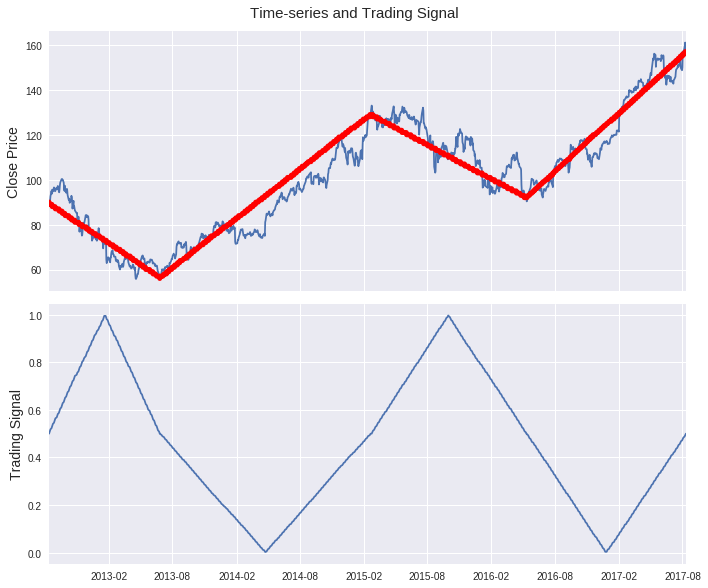

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex= True, figsize = (10, 8))
fig.suptitle("Time-series and Trading Signal", y = 1.02, size = 15)
xx = np.arange(len(close))
#ax1.plot(piece, c = "red")
apple["Close"].plot(ax = ax1 )
ax1.set_ylabel("Close Price", size = 14)

EPSILON = 20
piece, lines, points = PLR(close, EPSILON)
ax1.plot(apple.index, piece, c = "red", linewidth = 5, label = "PLR (threshold 20)")

ts= trading_signal(close, EPSILON)
ax2.plot(apple.index, ts)
ax2.set_ylabel("Trading Signal", size = 14)

plt.tight_layout()

### Adding Trading Signal (y) to TI's (x) of one stock:

In [27]:
apple['Trading Signal'] = ts 

In [47]:
apple_technicals = pd.read_csv("data/sandp500/individual_stocks_5yr_TECHNICALS/AAPL_data.csv")

In [48]:
apple_technicals['Target'] = ts

In [49]:
apple_technicals.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Name,Acc/Dist_ROC_1,ADX_14_50,...,RSI_12,STD_5,STD_20,SO%d_5,SO%d_20,SO%k,Trix_5,Trix_20,TSI_25_13,Target
0,0,2012-08-13,89.06,90.00,89.04,90.00,69707463,AAPL,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,0.0,NaN,0.500000
1,1,2012-08-14,90.27,91.23,90.03,90.24,85041824,AAPL,-0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.175000,NaN,NaN,NaN,0.504587
2,2,2012-08-15,90.19,90.57,89.68,90.12,64377278,AAPL,-0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.494382,NaN,NaN,NaN,0.509174
3,3,2012-08-16,90.17,90.97,90.07,90.91,63694204,AAPL,0.0,NaN,...,NaN,NaN,NaN,0.679983,NaN,0.933333,NaN,NaN,NaN,0.513761
4,4,2012-08-17,91.43,92.60,91.26,92.59,110689894,AAPL,0.0,NaN,...,NaN,1.075672,NaN,0.799968,NaN,0.992537,NaN,NaN,NaN,0.518349


In [75]:
apple_technicals.to_csv('data/sandp500/individual_stocks_5yr_TECHNICALS/APPL_data.csv')

In [76]:
abbvie = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS/ABBV_data.csv')
close = abbvie['Close'].values
ts = trading_signal(close, 5)

Figure out a way to tune Epsilon so the below code works in generating y's:

In [77]:
# #create a list of the different tickers 
# individuals = os.listdir(path = "data/sandp500/individual_stocks_5yr/")

# #iterate through all of the csv files
# for csv in individuals:
#     #only create paths with .csv included in the list
#     if '.csv' in csv:
#             #create a path with each csv
#             csv_path = "data/sandp500/individual_stocks_5yr_TECHNICALS/" + csv
#             #create a df with path
#             df = pd.read_csv(csv_path)
#             #define close as the closing values from the stock's historical price data 
#             close = df["Close"].values
#             #define epsilon for PLR as 20 
#             EPSILON = 20 
#             #find the trading signals of the stock using the defined epsilon and close 
#             ts= trading_signal(close, 20)
# #                 #add a feature called Target with the trading signal 
# #                 df['Target'] = ts
# #                 #save the cleaned df to csv in the individual_stocks_5yr_TECHNICALS_clean folder
# #                 df.to_csv(f"data/sandp500/individual_stocks_5yr_TECHNICALS/{csv}")
           
# #             except:
# #                 print(f"Adding target data to techincals failed on {csv}")
